In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np


In [27]:
#Preprocess the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [40]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss_values = []
net=Net()

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            train_loss_values.append(running_loss / 2000)
            running_loss = 0.0

print('Finished')


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Accuracy of the model on the 10000 test images: 50.8%


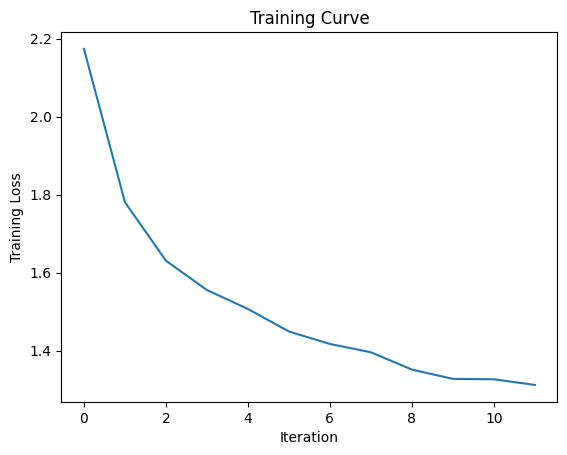

In [33]:
import matplotlib.pyplot as plt
# Plot the training curve
plt.plot(train_loss_values)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Curve')
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Assuming 'net' is your trained model
net.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test set to collect predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

# Generate the classification report
target_names = classes  # Assuming 'classes' contains the class names
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print(report)

              precision    recall  f1-score   support

       plane       0.70      0.33      0.45      1000
         car       0.78      0.56      0.65      1000
        bird       0.35      0.51      0.41      1000
         cat       0.36      0.21      0.27      1000
        deer       0.47      0.40      0.43      1000
         dog       0.33      0.73      0.46      1000
        frog       0.70      0.56      0.62      1000
       horse       0.64      0.47      0.54      1000
        ship       0.59      0.74      0.65      1000
       truck       0.63      0.58      0.60      1000

    accuracy                           0.51     10000
   macro avg       0.55      0.51      0.51     10000
weighted avg       0.55      0.51      0.51     10000



In [35]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1_1(x))
        x = nn.functional.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = nn.functional.relu(self.conv2_1(x))
        x = nn.functional.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:

train_loss_values = []

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            train_loss_values.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')


[1, 2000] loss: 0.000
[1, 4000] loss: 0.000
[1, 6000] loss: 0.000
[1, 8000] loss: 0.000
[1, 10000] loss: 0.000
[1, 12000] loss: 0.000
[2, 2000] loss: 0.000
[2, 4000] loss: 0.000
[2, 6000] loss: 0.000
[2, 8000] loss: 0.000
[2, 10000] loss: 0.000
[2, 12000] loss: 0.000
Finished Training


In [47]:
correct = 0
total = 0

# Set the model to evaluation mode
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 11.86%


In [54]:
#second CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss_values = []

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            train_loss_values.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')


[1, 2000] loss: 2.291
[1, 4000] loss: 2.038
[1, 6000] loss: 1.880
[1, 8000] loss: 1.763
[1, 10000] loss: 1.672
[1, 12000] loss: 1.627
[2, 2000] loss: 1.542
[2, 4000] loss: 1.470
[2, 6000] loss: 1.452
[2, 8000] loss: 1.419
[2, 10000] loss: 1.364
[2, 12000] loss: 1.343
[3, 2000] loss: 1.270
[3, 4000] loss: 1.240
[3, 6000] loss: 1.206
[3, 8000] loss: 1.214
[3, 10000] loss: 1.183
[3, 12000] loss: 1.167
[4, 2000] loss: 1.113
[4, 4000] loss: 1.090
[4, 6000] loss: 1.082
[4, 8000] loss: 1.083
[4, 10000] loss: 1.072
[4, 12000] loss: 1.064
[5, 2000] loss: 1.003
[5, 4000] loss: 0.990
[5, 6000] loss: 1.000
[5, 8000] loss: 0.979
[5, 10000] loss: 1.003
[5, 12000] loss: 0.969
[6, 2000] loss: 0.893
[6, 4000] loss: 0.924
[6, 6000] loss: 0.949
[6, 8000] loss: 0.913
[6, 10000] loss: 0.911
[6, 12000] loss: 0.920
[7, 2000] loss: 0.843
[7, 4000] loss: 0.862
[7, 6000] loss: 0.870
[7, 8000] loss: 0.883
[7, 10000] loss: 0.874
[7, 12000] loss: 0.890
[8, 2000] loss: 0.779
[8, 4000] loss: 0.796
[8, 6000] loss: 0.

In [56]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 69.64%


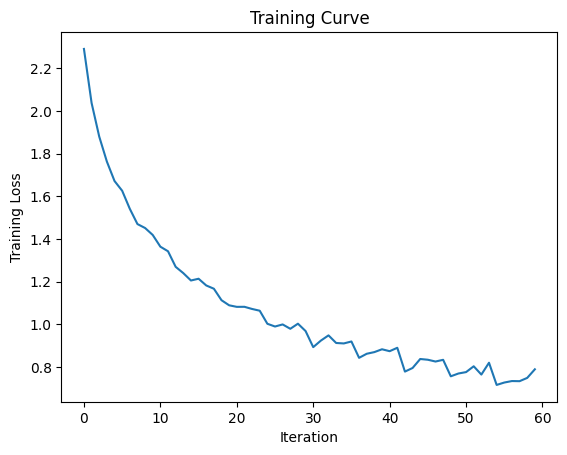

NameError: name 'accuracy_values' is not defined

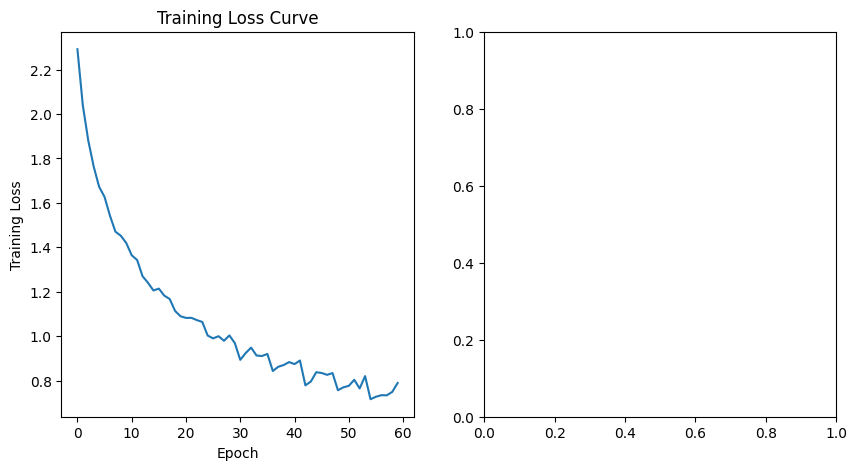

In [58]:
# Plot the training curve
plt.plot(train_loss_values)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Curve')
plt.show()


In [59]:
from sklearn.metrics import classification_report

# Assuming 'net' is your trained model
net.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test set to collect predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        predicted_labels.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

# Generate the classification report
target_names = classes  # Assuming 'classes' contains the class names
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print(report)


              precision    recall  f1-score   support

       plane       0.72      0.84      0.77      1000
         car       0.86      0.88      0.87      1000
        bird       0.72      0.55      0.62      1000
         cat       0.53      0.60      0.57      1000
        deer       0.69      0.70      0.70      1000
         dog       0.63      0.63      0.63      1000
        frog       0.81      0.80      0.81      1000
       horse       0.77      0.81      0.79      1000
        ship       0.88      0.79      0.83      1000
       truck       0.83      0.80      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

